In [2]:
## IMPORTS

# External modules
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import time
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Project modules
import filter

In [3]:
## FUNCTIONS


## DATAFRAME CREATION
def get_artworks_df():
    artworks = pd.read_csv('../temporary-files/saatchi_artworks_info.csv')
    artworks.rename(columns=lambda x: x.title(), inplace=True)
    artworks.rename(columns={'Price': 'Price (US$)', 'Size': 'Size (in²)'}, inplace=True)
    artworks = calculate_area_and_price_per_area(artworks)

    artworks.dropna(subset=['Price (US$)', 'Size (in²)'])
    
    for column_name in ['Styles', 'Mediums', 'Subjects', 'Materials']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(',')])

    # Filter out non 'one-of-a-kind' artworks
    artworks = artworks[artworks['Original'] == 'One-of-a-kind Artwork']

    for column_name in ['Title']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(' ')])

    # column Artist as single-item list
    artworks['Artist'] = artworks['Artist'].apply(lambda x: [x])
    
    # Remove outliers (artworks with Price (US$/in²) in the 5% and 95% percentiles)
    artworks = artworks[artworks['Price (US$/in²)'] > artworks['Price (US$/in²)'].quantile(0.05)]
    artworks = artworks[artworks['Price (US$/in²)'] < artworks['Price (US$/in²)'].quantile(0.95)]
    return artworks


def calculate_area_and_price_per_area(dataframe):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe['Size (in²)']):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size (in²)'] = total_area
            except:
                df.at[i, 'Size (in²)'] = 'NaN'
    df['Price (US$/in²)'] = df['Price (US$)'] / df['Size (in²)']

    return df


def get_occurrence_count_on_col_dict(values):
    # Get all unique values from the column
    occurrences_counts_dict = dict(Counter(values))
    return occurrences_counts_dict


def create_segments_dataframe(segments_dfs):
    all_segments_df = pd.DataFrame(index=segments_dfs.keys(),
                                   columns=['Mean Price (US$)', 'Median Price (US$)',
                                            'Standard Dev Price (US$)', 'Variance (US$)',
                                            'Mean Price (US$/in²)', 'Median Price (US$/in²)',
                                            'Standard Dev Price (US$/in²)', 'Variance (US$/in²)' 'Count'])
    for key, value in segments_dfs.items():
        all_segments_df.loc[key, 'Mean Price (US$)'] = value['Price (US$)'].mean().round(0)
        all_segments_df.loc[key, 'Median Price (US$)'] = value['Price (US$)'].median().round(0)
        all_segments_df.loc[key, 'Standard Dev Price (US$)'] = value['Price (US$)'].std().round(0)
        all_segments_df.loc[key, 'Variance (US$)'] = value['Price (US$)'].var().round(0)

        all_segments_df.loc[key, 'Mean Price (US$/in²)'] = value['Price (US$/in²)'].mean().round(2)
        all_segments_df.loc[key, 'Median Price (US$/in²)'] = value['Price (US$/in²)'].median().round(2)
        all_segments_df.loc[key, 'Standard Dev Price (US$/in²)'] = value['Price (US$/in²)'].std().round(2)
        all_segments_df.loc[key, 'Variance (US$/in²)'] = value['Price (US$/in²)'].var().round(2)
        
        all_segments_df.loc[key, 'Count'] = len(value)
    all_segments_df.sort_values(by='Mean Price (US$)', ascending=False, inplace=True)
    return all_segments_df


# def group_by_segments(artworks_data, column_name, column, occurrences_threshold):

#     segments_dfs = get_dfs_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)

#     create_segments_dataframe(segments_dfs)
    
#     # New dataframe for each segment
#     segments_dfs = {}
#     for key, value in occurrence_count_on_col_dict.items():
#         if value > occurrences_threshold:
#             segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
#     return segments_dfs



def analyse_by_column(dataframe, column_name, threshold):
    artworks_count_by_segment = dataframe[column_name].value_counts()
    artworks_count_pct_by_segment = artworks_count_by_segment / dataframe[column_name].value_counts().sum()
    selection = artworks_count_by_segment[artworks_count_by_segment > threshold].index
    dataframe = dataframe[dataframe[column_name].isin(selection)]
    return dataframe

def compare_segments(dataframe, segments_to_compare, x_column_name, y_column_name):
    for segment in segments_to_compare:

        if segment == 'All':
            segment_df = dataframe
        else:
            segment_df = segments_dfs[segment]

        x = segment_df[[x_column_name]]
        y = segment_df[y_column_name]
        print('stats:', get_stats(segment_df, x, y))
        get_all_models(x, y)

        xlim = (0, 10000)
        ylim = (0, 40000)


def get_segments_for_column(column):
    segments = [value for sublist in column for value in sublist]
    return segments


def segment_and_clean_data(artworks_data, column_name, occurrences_threshold):
    column = artworks_data[column_name]
    
    if column_name == 'Artist':
        segments_in_column_list = artworks_data['Artist'].apply(lambda x: x[0]).to_list()
    else:
        segments_in_column_list = get_segments_for_column(column)
    occurrence_count_on_col_dict = get_occurrence_count_on_col_dict(segments_in_column_list)
    
    filtered_artworks_data = remove_empty_rows(artworks_data, column)
    filtered_artworks_data = filtered_artworks_data.dropna(subset=['Price (US$)', 'Size (in²)'])
    filtered_artworks_data[column_name] = column
    
    segments_dfs = get_dataframes_for_segments(filtered_artworks_data, column_name, occurrence_count_on_col_dict, occurrences_threshold)
    all_segments_df = create_segments_dataframe(segments_dfs)
    
    return filtered_artworks_data, all_segments_df, segments_dfs


def remove_empty_rows(dataframe, column):
    return dataframe[column.apply(lambda x: len(x) > 0)]


def get_dataframes_for_segments(dataframe, column_name, occurrence_count_on_col_dict, occurrences_threshold):
    segments_dfs = {}
    for key, value in occurrence_count_on_col_dict.items():
        if value > occurrences_threshold:
            segments_dfs[key] = dataframe[dataframe[column_name].apply(lambda x: key in x)]
    return segments_dfs



def prepare_dataframe_dummies(artworks_data, column_name, segments_dfs):
    dummies_for_segment = artworks_data[['Price (US$)', column_name]].dropna(subset=['Price (US$)'])
    
    for key, value in segments_dfs.items():
        dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
    
    return dummies_for_segment


def get_dummies_for_all_segments(artworks, columns_names):
    dummies_for_all_segments = pd.DataFrame()

    # get one df with dummies for styles, mediums, materials and subjects
    for column_name in columns_names:
        
        if column_name == 'Artist':
            occurrences_threshold = 5
        else:
            occurrences_threshold = artworks.shape[0] / 100
        
        segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)[2]
        dummies_for_segment = prepare_dataframe_dummies(artworks, column_name, segments_dfs).drop(columns=['Price (US$)'])
        # concat dummies_for_segment to dummies_for_all_segments
        dummies_for_all_segments = pd.concat([dummies_for_all_segments, dummies_for_segment], axis=1)


    dummies_for_all_segments.drop(columns=['Styles', 'Mediums', 'Materials', 'Subjects'], inplace=True)

    # add price, size, country
    columns_to_add = ['Size (in²)', 'Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created']
    for column_name in columns_to_add:
        dummies_for_all_segments[column_name] = artworks[column_name]

    return dummies_for_all_segments


def analyse_by_segments(artworks, column_name, sort_by, min_frequency):
    artworks_by_segment = analyse_by_column(artworks, column_name, min_frequency)
    # Get mean price per segment as 'Mean Price' column
    mean_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'mean'})
    median_price_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$)': 'median'})
    mean_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'mean'})
    median_price_per_in_by_segment = artworks_by_segment.groupby(column_name).agg({'Price (US$/in²)': 'median'})
    col_analysis_by_segment = pd.concat([mean_price_by_segment, median_price_by_segment, mean_price_per_in_by_segment, median_price_per_in_by_segment, artworks[column_name].value_counts()], axis=1)
    col_analysis_by_segment.columns = ['Mean Price (US$)', 'Median Price (US$)','Mean Price (US$/in²)', 'Median Price (US$/in²)', 'Count']
    # filter out segments with less than [min_frequency] artworks
    col_analysis_by_segment = col_analysis_by_segment[col_analysis_by_segment['Count'] > min_frequency]

    col_analysis_by_segment.sort_values(by=sort_by, ascending=False, inplace=True)
    col_analysis_by_segment = col_analysis_by_segment.dropna()

    return col_analysis_by_segment


def get_descritive_analysis_of_column(dataframe, column_name):
    column = dataframe[column_name]

    descritive_df = pd.DataFrame()
    descritive_df.loc[0, 'max'] = column.max()
    descritive_df.loc[0, 'min'] = column.min()
    descritive_df.loc[0, 'mean'] = column.mean()
    descritive_df.loc[0, 'median'] = column.median()
    descritive_df.loc[0, 'stdev'] = column.std()
    descritive_df.loc[0, 'var'] = column.var()

    return descritive_df

In [4]:
## MODELS


def get_stats(x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(variable), 2)
        min_variable = round(min(variable), 2)
        mean_variable = round(variable.mean(), 2)
        median_variable = round(variable.median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


## GET MODELS

def get_decision_tree(X_train, y_train):
    decision_tree = DecisionTreeRegressor(random_state=42)
    decision_tree.fit(X_train, y_train)
    return decision_tree

def get_linear_regression(X_train, y_train):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    return linear_regression

def get_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=1)
    rf_model.fit(X_train, y_train)
    return rf_model

def get_gradient_boosting(X_train, y_train):
    # get gradient boosting model
    gb_model = GradientBoostingRegressor(random_state=1)
    gb_model.fit(X_train, y_train)
    return gb_model

# gives a dataframe taking models as columns and score as rows
def get_all_models(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

    models = {'Linear regression': get_linear_regression(x_train, y_train),
              'Decision tree': get_decision_tree(x_train, y_train),
              'Random forest': get_random_forest(x_train, y_train),
              'Gradient boosting': get_gradient_boosting(x_train, y_train)}
    
    models_df = pd.DataFrame(columns=models.keys())
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        p = x_test.shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mean_error = mean_absolute_error(y_test, y_pred)
        median_error = median_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        pearson = np.corrcoef(y_test.to_numpy(), y_pred)[0, 1]

        models_df.loc['R² Score', model_name] = r2
        models_df.loc['Adjusted R² Score', model_name] = adj_r2
        models_df.loc['Pearson Correl Predicted-Actual', model_name] = pearson
        models_df.loc['Mean Absolute Error', model_name] = mean_error
        models_df.loc['Median Absolute Error', model_name] = median_error
        models_df.loc['Mean Squared Error', model_name] = mse

        # Round values
        models_df = models_df.round(2)

    return models_df, models

In [5]:
## CHARTS

dark_green_color_code = '#195921'
gold_color_code = '#FFD700'
black_color_code = '#000000'
salmon_color_code = '#FA8072'

def plot_segment_chart(dataframe, segments_column_name, bar_column_name, line_columns_names, title):
    bar_color_code = dark_green_color_code
    line_colors_codes = [gold_color_code, black_color_code]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(dataframe.index, dataframe[bar_column_name], color=bar_color_code)
    for line_column_name in line_columns_names:
        ax2.plot(dataframe.index, dataframe[line_column_name], label=line_column_name, color=line_colors_codes.pop(0))
    ax2.legend()
    ax1.set_xticklabels(dataframe.index, rotation=90)
    ax1.set_ylabel(bar_column_name)
    ax2.set_ylabel(str(line_columns_names))
    ax1.set_xlabel(segments_column_name)
    ax1.set_title(title)
    # beautify and enhance readability of the chart
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax1.tick_params(axis='x', which='major', labelsize=8)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax2.tick_params(axis='y', which='major', labelsize=8)

    plt.show()


def plot_scatter(dataframe, x_column_name, y_column_name, title, log=False):
    if log:
        x = np.log(dataframe[x_column_name].astype(float))
        y = np.log(dataframe[y_column_name].astype(float))
    else:
        x = dataframe[x_column_name].astype(float)
        y = dataframe[y_column_name].astype(float)

    plt.figure()
    plt.title(title)
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.scatter(x=x, y=y, c=dark_green_color_code)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),c=salmon_color_code)

    plt.show()


def plot_histogram(column, title, x_label, y_label, bins=50):
    column.hist(bins=bins, color=dark_green_color_code)
    # line of the mean
    plt.axvline(column.mean(), color='gold', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [6]:
artworks = get_artworks_df()

# FILTER BY PERCENTILE between 0.25 and 0.75
# artworks = artworks[artworks['Size (in²)'] > artworks['Size (in²)'].quantile(0.25)]

quantile = ''

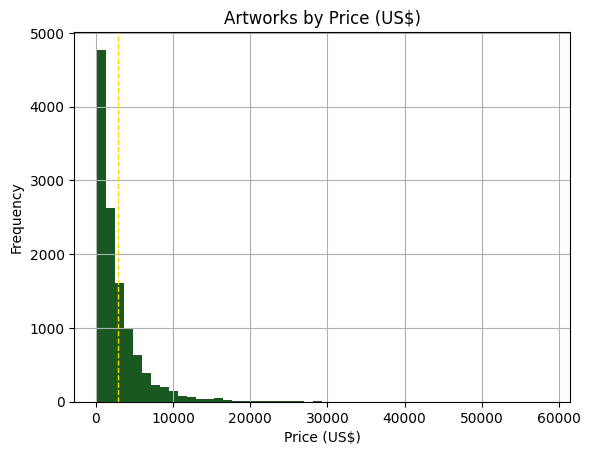

       max    min        mean  median        stdev           var
0  58550.0  135.0  2851.58432  1721.0  3428.282171  1.175312e+07


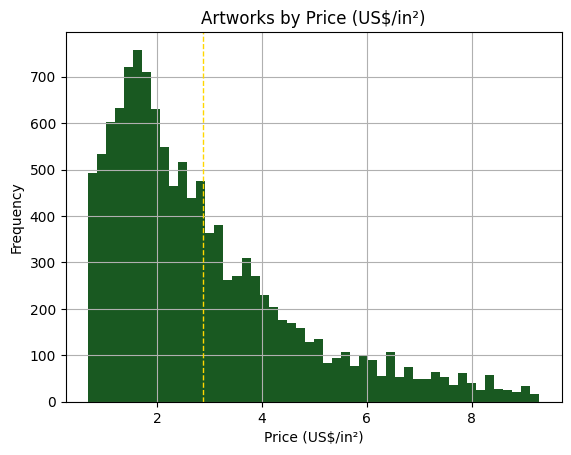

        max      min      mean    median     stdev       var
0  9.285972  0.68125  2.868842  2.356997  1.799354  3.237675


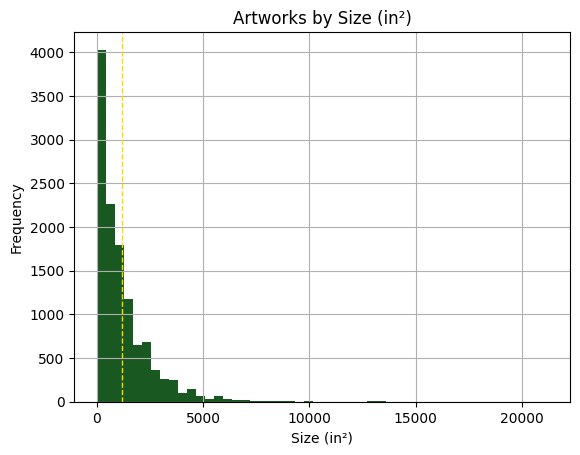

        max    min        mean  median       stdev           var
0  21206.64  17.49  1215.04938  774.54  1343.44413  1.804842e+06


<Figure size 640x480 with 0 Axes>

In [7]:
## DESCRITIVE ANALYSIS OF COLUMN

columns_names = ['Price (US$)', 'Price (US$/in²)', 'Size (in²)']



for column_name in columns_names:
    descritive_df = get_descritive_analysis_of_column(artworks, column_name)
    plot_histogram(artworks[column_name], f'Artworks by {column_name}', column_name, 'Frequency')
    print(descritive_df)

    modified_column_name = column_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    
    # save chart
    plt.savefig(f'./charts/descriptive_analysis_{modified_column_name}{quantile}.png', bbox_inches='tight')
    # download df as csv
    descritive_df.to_csv(f'data_files/descriptive_analysis_{modified_column_name}{quantile}.csv', index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2998301306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


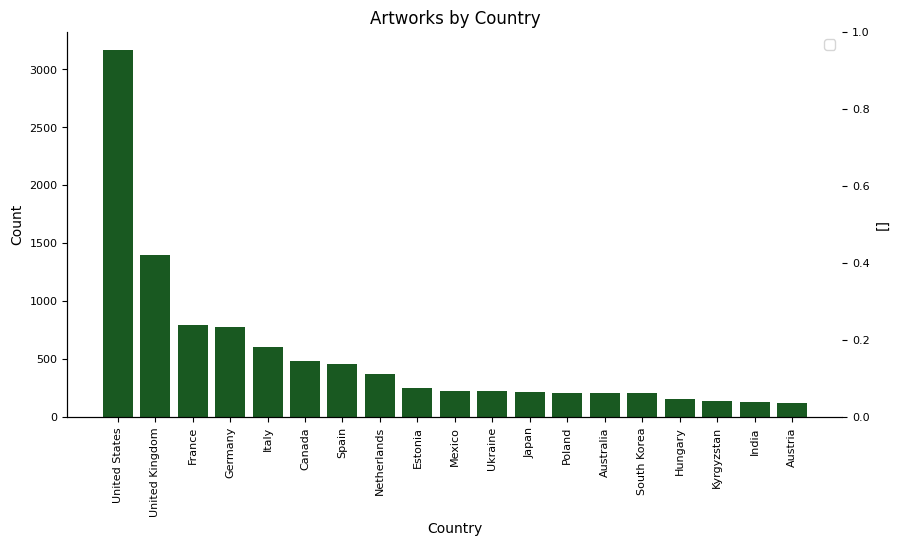

<Figure size 640x480 with 0 Axes>

In [8]:
## ARTWORKS BY COLUMN

column_name1 = 'Country'
sort_by1 = 'Count'
min_frequency1 = artworks.shape[0] * 0.01

col_analysis_by_segment = analyse_by_segments(artworks, column_name1, sort_by1, min_frequency1)
plot_segment_chart(col_analysis_by_segment, column_name1, 'Count', [], 'Artworks by ' + column_name1)
col_analysis_by_segment

# download the chart
plt.savefig('artworks_by_{column_name1}.png')

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2998301306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


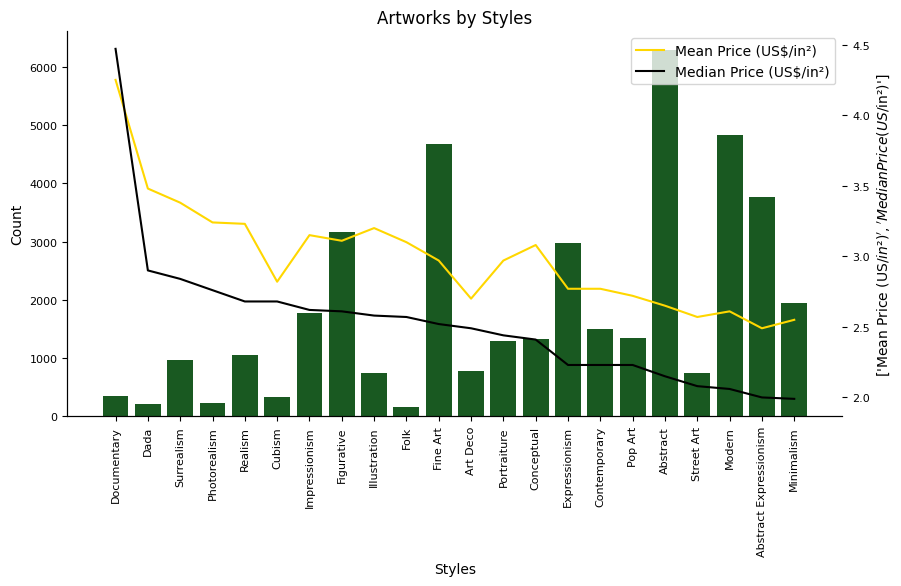

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2998301306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


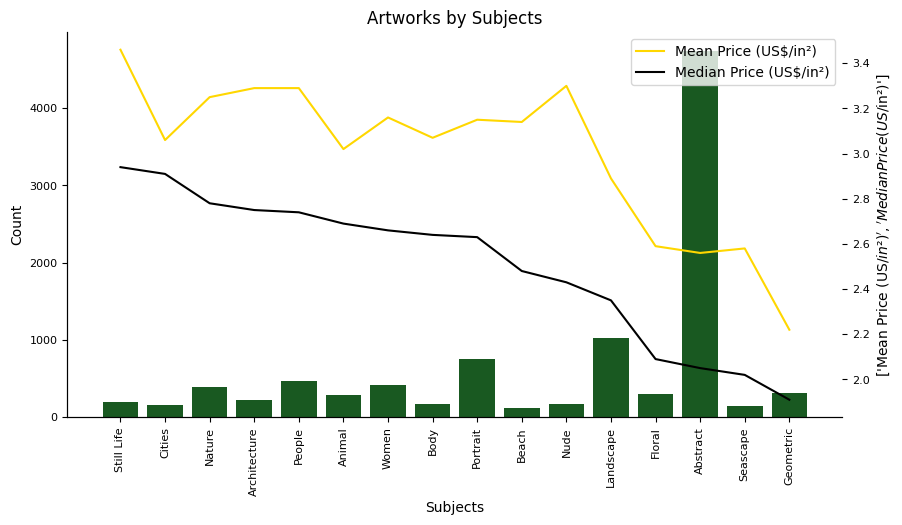

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2998301306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


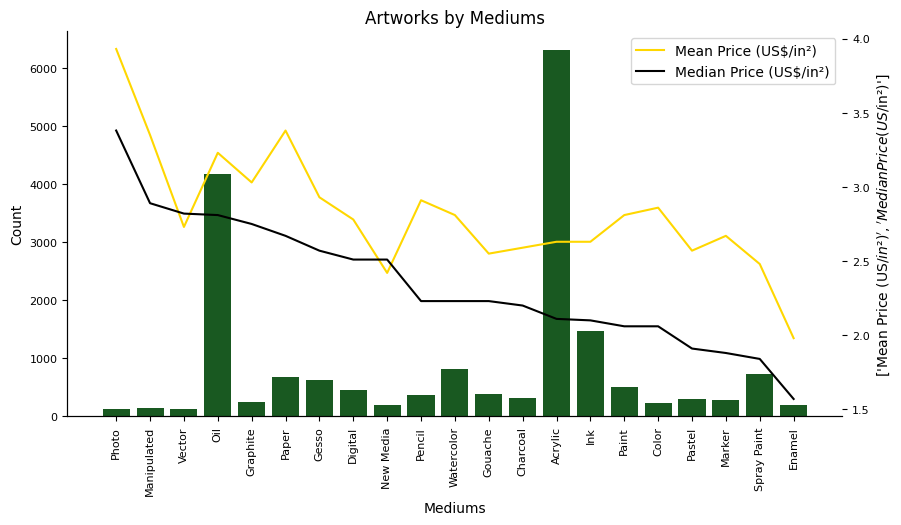

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2998301306.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(dataframe.index, rotation=90)


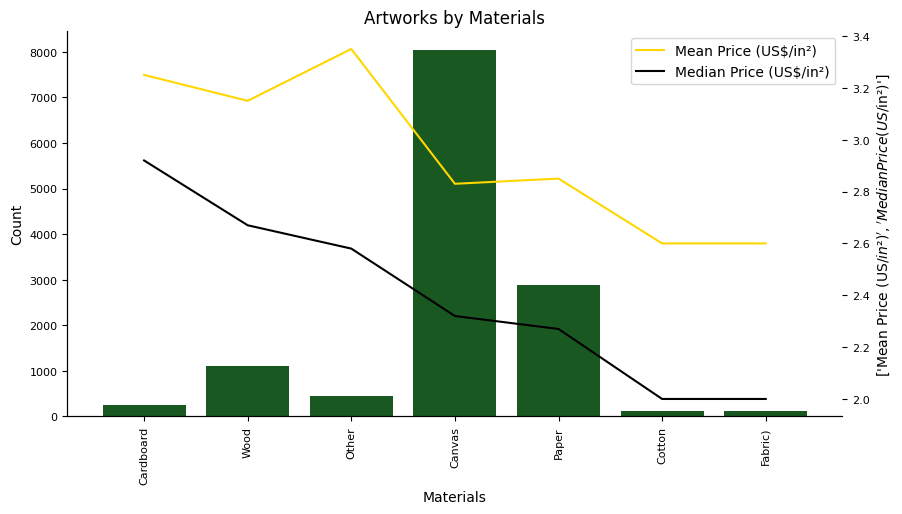

/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2578601641.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2578601641.py:159: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummies_for_segment[key] = artworks_data[column_name].apply(lambda x: True if key in x else False)
/var/folders/rt/d94hn0nj1cl2kykjjkdpswxw0000gn/T/ipykernel_1310/2578601641.py:

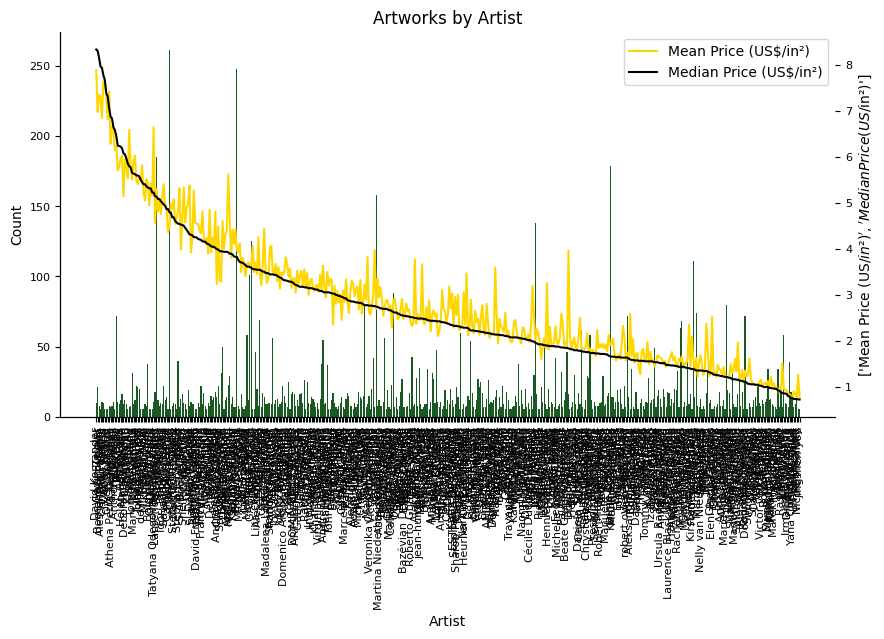

In [9]:
## ANALYSE CATEGORIES

categories_columns_list = ['Styles', 'Subjects', 'Mediums', 'Materials', 'Artist']

sort_by = 'Median Price (US$/in²)'

categories_dfs = {}
categories_models_metrics_df = {}
categories_models = {}

for column_name in categories_columns_list:

    if column_name == 'Artist':
        occurrences_threshold = 5
    else:
        occurrences_threshold = artworks.shape[0]/100

    column = artworks[column_name]
    filtered_artworks_data, all_segments_from_category_df, segments_dfs = segment_and_clean_data(artworks, column_name, occurrences_threshold)
    dummies_for_category = prepare_dataframe_dummies(artworks, column_name, segments_dfs)

    # get all models to dummies_for_segment
    x = dummies_for_category.drop(['Price (US$)', column_name], axis=1)
    y = dummies_for_category['Price (US$)']
    category_models_metrics_df, category_models = get_all_models(x, y)

    categories_models_metrics_df[column_name] = category_models_metrics_df
    categories_models[column_name] = category_models

    all_segments_from_category_df.drop('Variance (US$/in²)Count', axis=1, inplace=True)
    all_segments_from_category_df.sort_values(by=sort_by, ascending=False, inplace=True)

    plot_segment_chart(all_segments_from_category_df, column_name, 'Count', ['Mean Price (US$/in²)', 'Median Price (US$/in²)'], 'Artworks by ' + column_name)
    categories_dfs[column_name] = all_segments_from_category_df

    # save all_segments_from_category_df as csv
    all_segments_from_category_df.to_csv(f'data_files/descriptive_analysis_{column_name}.csv', index=False)

In [10]:
## MODEL FOR SIZE AND CATEGORIES

# ignorando warnings porque essa célula levanta muitos warnings de performance do pandas (quando se inclui a coluna 'Artist')
import warnings
warnings.filterwarnings('ignore')


categories_columns_list = ['Styles', 'Subjects', 'Mediums', 'Materials', 'Artist']

dummies_for_all_segments = get_dummies_for_all_segments(artworks, categories_columns_list)
dummies_for_all_segments.columns

# apply models to dummies_for_all_segments
x = dummies_for_all_segments.drop(columns=['Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created', 'Artist'])
y = dummies_for_all_segments['Price (US$)']
models_metrics_df, models = get_all_models(x.values, y)
models_metrics_df

# save models_metrics_df as csv
models_metrics_df.to_csv('models_metrics_df.csv', index=False)

In [11]:
# CORRELATION MATRIX BETWEEN DUMMIES

data = dummies_for_all_segments.drop(columns=['Price (US$)', 'Price (US$/in²)', 'Country', 'Favorite', 'Url', 'Title', 'Artist Produced Limited Edition Of', 'Original Created'])
correlation_matrix = data.corr()
correlation_matrix
# show only correlations above 0.5 but different than 1
correlation_matrix[(correlation_matrix > 0.5) & (correlation_matrix < 1)]
# show correlations between 0.5 and 1 (without duplicates)
correlation_matrix[(correlation_matrix > 0.5) & (correlation_matrix < 1)].stack().drop_duplicates()

ValueError: setting an array element with a sequence.

In [ ]:
## GET FEATURE IMPORTANCES

rf_model = models['Random forest']

feature_importances_df = pd.DataFrame(rf_model.feature_importances_,
                                      index = x.columns,
                                        columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)
feature_importances_df.head()

,Feature Importance
Size (in²),0.667767
Kris Gebhardt,0.012823
Christian Hetzel,0.011528
Photorealism,0.008064
Eric Merola,0.007927


In [ ]:
## GET CATEGORY-CLUSTERED FEATURE IMPORTANCES

# {Category: Segment} dictionay
category_segments_dict = {}
for column_name in categories_columns_list:
    categories = categories_dfs[column_name].index.tolist()
    category_segments_dict[column_name] = categories

# Invert dictionary: {Segment: Category}
segment_categories_dict = {}
segment_categories_dict['Size (in²)'] = 'Size (in²)'
for category, segments in category_segments_dict.items():
    for segment in segments:
        segment_categories_dict[segment] = category

feature_importances_df['Category'] = feature_importances_df.index.map(segment_categories_dict)

feature_importances_df.groupby('Category').sum().sort_values('Feature Importance', ascending=False).head(10)

# save to csv
feature_importances_df.to_csv('data/rf_model_feature_importances.csv')

,Feature Importance
Category,
Size (in²),0.667767
Artist,0.173890
Styles,0.079451
Mediums,0.038083
Subjects,0.027752
Materials,0.013057


In [ ]:
## DISTRIBUTION OF RESIDUALS

# get y_train and y_pred
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
y_pred = rf_model.predict(x_test)

residuals = y_test - y_pred

plot_histogram(residuals, title='Residuals distribution', x_label='Residuals', y_label='Frequency', bins=20)


## distribuição por percentis

In [ ]:
## QUANTILE LOSS

import numpy as np

def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return np.maximum(quantile * errors, (quantile - 1) * errors)

quantiles = [0.1, 0.5, 0.9]

for quantile in quantiles:
    loss = quantile_loss(y_test, y_pred, quantile)
    quantile_loss_value = np.mean(loss)
    print(f"Quantile Loss ({quantile}): {quantile_loss_value:.4f}")

In [ ]:
## PLOT PRICE VS SIZE

plot_scatter(dummies_for_all_segments, 'Size (in²)', 'Price (US$)', 'Size vs Price', True)

In [ ]:
## ESTUDOS DE CASO:
# QUADROS MAIS CAROS
# MAIORES RESÍDUOS


In [ ]:
## PLOT Y_TEST VS Y_PRED

# plot results of the random forest model (y_pred) vs actual data (y_test)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
rf_model = models['Random forest']
y_pred = rf_model.predict(x_test)
test_df = pd.DataFrame({'Actual Price (US$)': y_test, 'Predicted Price (US$)': y_pred})

## adicionar linha identidade e pegar a inclinação dela
plot_scatter(test_df, 'Actual Price (US$)', 'Predicted Price (US$)', 'Price: Actual x Predicted')

In [ ]:
# get artworks with larger residuals

test_df['Residual'] = test_df['Predicted Price (US$)'] - test_df['Actual Price (US$)']
# get 0.75 quantile
q75 = test_df['Residual'].quantile(0.75)
large_residual_indices = test_df[test_df['Residual'] > q75].index
# get the artworks with index in large_residual_indices
large_residual_df = artworks.loc[large_residual_indices]
large_residual_df.Description

In [ ]:
## DESCRITIVE ANALYSIS OF COLUMN

columns_names = ['Price (US$)', 'Price (US$/in²)', 'Size (in²)']

for column_name in columns_names:
    descritive_df = get_descritive_analysis_of_column(large_residual_df, column_name)
    print(descritive_df)

In [ ]:
## APPLYING MODELS TO SEGMENTS

# multi variate linear regression with price as y and all segments as x
x = dummies_for_segment.drop(['Price (US$)', column_name], axis=1)
# dependent variable
y = dummies_for_segment['Price (US$)']

print('Models for',column_name ,'x','Price (US$)')
get_all_models(x, y)
print()
print(dummies_for_segment.columns)

In [ ]:
# ## COMPARE SEGMENTS:

# artworks_data = get_artworks_df()
# ## COLUMN CHOSEN TO DEFINE SEGMENTS
# column_name = 'Styles'
# column = artworks_data.Styles
# occurrences_threshold = 0

# print('IN EACH LISTED SEGMENT, HOW STRONGLY DOES THE PRICE OF AN ARTWORK DEPEND ON ITS SIZE?')
# print()


# segments_dfs = group_by_segments(artworks_data, column_name, column, occurrences_threshold)


# segments_to_compare = ['Impressionism', 'Photorealism']

# # Variables
# x_column_name = 'Size (in²)'
# y_column_name = 'Price (US$)'

# filtered_artworks_data = artworks_data[artworks_data[column_name].apply(lambda x: any(item in x for item in segments_to_compare))]

# compare_segments(filtered_artworks_data, segments_to_compare, x_column_name, y_column_name)